## Astronomy 406 "Computational Astrophysics" (Fall 2016)

### Week 14: Partial Differential Equations

<b>Reading:</b> notes below, as well as [$\S$20.0-20.4](https://umich.instructure.com/files/3258741/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes/).

Solving partial differential equations (PDE) is significantly more complex than ODE, because there are two or more indepednent variables.  We will consider one of the simpler cases, flux-conservative initial value problem in one spatial dimension plus time.

$$
    {\partial u \over\partial t} = - {\partial F(u) \over\partial x}
$$

where $F(u)$ is flux of quantity $u$. (Units of $F(u)$ is essentially 'velocity' (${dx} \over {dt}$) times 'u'.) This is a 'conservative' equation in that if u is not changing, flux is not changing.

There are several finite-difference schemes for solving this equation.  First, we need to set the spatial grid $x_i = i \, \Delta x$ for the $N$ points on box size $L$, $\Delta x \equiv L/N$.  We also need the temporal grid $t_n = n \Delta t$.

<b>Forward-Time-Centered-Space (FTCS) scheme</b>

$$
   {u_i^{n+1} - u_i^n \over \Delta t} = -{F_{i+1}^n - F_{i-1}^n \over 2\Delta x}, 
   \quad \mathrm{or} \quad
   u_i^{n+1} = u_i^n - \Delta t\ {F_{i+1}^n - F_{i-1}^n \over 2\Delta x}.
$$

<i>Forward-Time</i> because the time derivative is a forward step from $t_n$, <i>Centered-Space</i> because the spatial derivative is central around point $x_i$.

It is the simplest <i>explicit</i> scheme, meaning quantities at next step $n+1$ can be calculated explicitly from the quantities that are already known at step $n$.  However, this scheme is unconditionally unstable, according to the von Neumann stability analysis (see [$\S$20.1.1](https://umich.instructure.com/files/745838/download) in NR). The error grows as a power law with time.

This instability can be fixed by the <b>Lax scheme</b>

$$
   u_i^{n+1} = {u_{i+1}^n + u_{i-1}^n \over 2} - \Delta t\ {F_{i+1}^n - F_{i-1}^n \over 2\Delta x}.
$$

It can also be written as

$$
   {u_i^{n+1} - u_i^n \over \Delta t} = -{F_{i+1}^n - F_{i-1}^n \over 2\Delta x} +
   {u_{i+1}^n -2 u_i^n + u_{i-1}^n \over 2\Delta t},
$$

which is the FTCS representation of the equation

$$
    {\partial u \over\partial t} = - {\partial F(u) \over\partial x}
    + {(\Delta x)^2 \over 2\Delta t} {\partial^2 u \over\partial x^2}.
$$

Without the $-\partial F(u) \over\partial x$, we have diffusion equation. The additional term represents <i>numerical viscosity</i>.

Oftentimes $\Delta x$ is limited by the computer, so all we can do is adjust the timestep. Occasionally the velocity will also change, so we must always monitor the $v \Delta t < \Delta x$ condition, to prevent violation. (Thus always good idea to use adaptive time step.)

The Lax scheme is stable if the <i>Courant-Friedrichs-Lewy stability criterion</i> is satisfied: $v \Delta t < \Delta x$, where $v$ is characteristic velocity of the flow, $v = |F(u)/u|$.  Information about changes in variable $u$ propagates with the speed $v$, so this criterion requires that in a single step the differencing scheme uses only variables from a causally-connected spatial region.

There is also a second-order accurate in time <b>Lax-Wendroff scheme</b>, which uses mid-point values of the flux:

$$
   u_i^{n+1} = u_i^n - {\Delta t\over \Delta x} \left(
     {F(u_{i+1/2}^{n+1/2}) - F(u_{i-1/2}^{n+1/2})}\right),
$$

where the mid-points are calculated with the Lax scheme:

$$
   u_{i+1/2}^{n+1/2} = {u_{i+1}^n + u_{i}^n \over 2} - 
     {\Delta t\over \Delta x} \left({F_{i+1}^n - F_{i}^n}\right).
$$

All these schemes are implemented below.

In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 80
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def FTCS(rho, h, dt):
    # ip = i+1, accounting for periodic boundary conditions
    # im = i-1, accounting for periodic boundary conditions
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    r = rho - dt/(2.*h)*(Flux(rhop)-Flux(rhom))
    return r

def Lax(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    r = (rhop+rhom)/2. - dt/(2.*h)*(Flux(rhop)-Flux(rhom))
    return r

def LaxWendroff(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    Fi = Flux(rho)
    Fp = Flux(rhop)
    Fm = Flux(rhom)
    up = (rhop+rho)/2. - dt/h*(Fp-Fi)
    um = (rhom+rho)/2. - dt/h*(Fi-Fm)
    r = rho - dt/h*(Flux(up)-Flux(um))
    return r

We will take an example from Alejandro Garcia's book [Numerical Methods for Physics](http://www.algarcia.org/nummeth/nummeth.html).  Corresponding excerpt from the book is available [here](https://umich.instructure.com/files/3260017/download?download_frd=1).

Consider the <i>continuity equation</i> for density $\rho$, where the velocity is only a function of density:

$$
    {\partial \rho \over\partial t} = - {\partial\over\partial x} \rho v(\rho)
$$

It is a model for traffic flow going in a circle. When the density of cars is low (free road), the velocity is maximum possible for the car, $v_m$. We assume all cars have the same maximum speed. When the density is higher, traffic slows down because cars try to avoid collision. The maximum possible density ($\rho_m$) is when cars are touching bumper-to-bumper and the traffic stops (we assume to have only one lane - one-dimensional flow). Therefore, a simple model that describes this trend is

$$
   v(\rho) = v_m \left({1 - {\rho \over \rho_m}}\right).
$$

The continuity equation can be re-written as

$$
   {\partial \rho \over\partial t} = -c(\rho) {\partial\rho \over\partial x}, \quad
   c(\rho) = v_m \left({1 - {2\rho \over \rho_m}}\right).
$$

Here $c(\rho)$ is the speed at which waves in the flow will travel. Note that it can be both positive or negative, depending on density. However, $c(\rho) \le v(\rho)$, so the waves may never move faster than the cars.

We need to set up the spatial grid and time sequence. 

The initial density profile can be

$$
   \rho(x, t=0) = \begin{cases} 
     \rho_m \quad (\mathrm{for}\ {L \over 4} < x < {L \over 2}) \\ 
     0 \quad \mathrm{(otherwise)}
     \end{cases}
$$

so it is packed with maximum density in the second quarter of the race track, which goes from $x_0 = 0$ to $x_N = L$.

Assuming a circular track, we set <i>periodic boundary conditions</i>: $\rho(x_0) = \rho(x_N)$.

At time $t=0$ the cars are free to move. Not all cars can start moving immediately, if they are behind other cars. The density decreases as the cars separate, but this effect propages back into the stream of traffic as a wave with finite speed (it is called <i>rarefaction wave</i>).

In [4]:
def v(rho):
    return vm*(1.-rho/rhom)

def c(rho):
    return vm*(1.-2.*rho/rhom)

def Flux(rho):
    return rho*v(rho)

# periodic boundary conditions
def ip(i):
    return i+1 if (i < N-1) else 0 #i.e., we loop back around to the beginning.
    
def im(i):
    return i-1 if (i > 0) else N-1

# Lax-Wendroff scheme explicitly for this problem
def LaxWendroff2(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    Fi = Flux(rho)
    Fp = Flux(rhop)
    Fm = Flux(rhom)
    cp = c((rhop+rho)/2.)*(Fp-Fi)
    cm = c((rhom+rho)/2.)*(Fi-Fm)
    r = rho - dt/(2.*h)*(Fp-Fm) + (dt/h)**2/2.*(cp-cm)
    return r

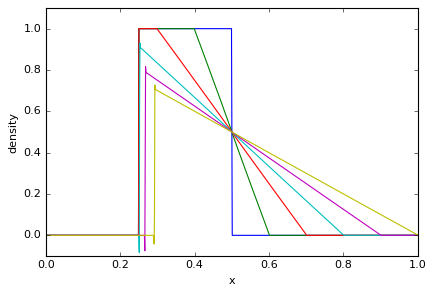

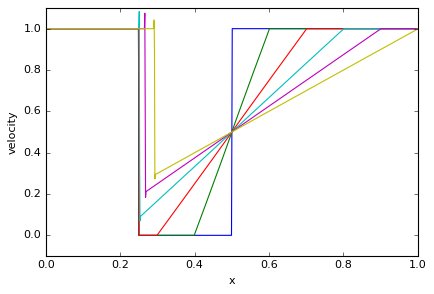

In [5]:
L = 1.           # box size
N = 1001         # number of cells
h = L/(N-1.)     # cell size
vm = 1.          # max velocity
rhom = 1.        # max density
dt = 0.001*L/vm  # time step

# initial conditions
rho = np.zeros([N])
for i in range(N/4, N/2):
    rho[i] = rhom
rho[N/2] = rhom/2.
x = np.arange(0., L+h/2., h)

def run_track(rho, Nt):
    """
        rho = initial density profile
        Nt = number of outputs, every 0.1 of box length
    """
    t = 0.
    tstep = 0.1*L/vm
    tnext = tstep
    k = 1
    den = np.zeros([Nt,N]) 
    den[0] = rho
    while k < Nt:
        #rho = FTCS(rho, h, dt)
        #rho = Lax(rho, h, dt)
        #rho = LaxWendroff(rho, h, dt)
        rho = LaxWendroff2(rho, h, dt)
        t += dt
        if t >= tnext:  
            den[k] = rho
            tnext += tstep
            k += 1
    return den

Nt = 12    # number of outputs
nshow = 6  # show these outputs first

den = run_track(rho, Nt)

plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('density')
[plt.plot(x, den[k], '-') for k in range(nshow)]
plt.show()

plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('velocity')
[plt.plot(x, v(den[k]), '-') for k in range(nshow)]
plt.show()

At first, we see the right edge of the density bump to expand linearly forward. The left edge begins moving only when the density drops below the maximum and traffic is no longer bumper-to-bumper.

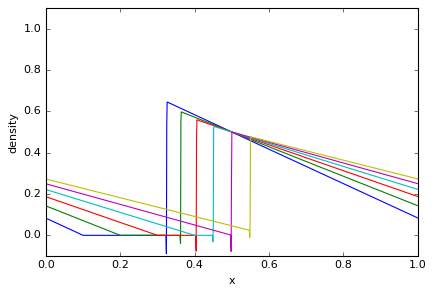

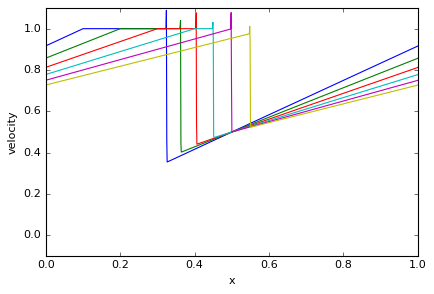

In [6]:
plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('density')
[plt.plot(x, den[k], '-') for k in range(nshow,Nt)]
plt.show()

plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('velocity')
[plt.plot(x, v(den[k]), '-') for k in range(nshow,Nt)]
plt.show()

Then we see a <i>shock wave</i> (discontinuity in density and velocity) developing around $x=0.5$, where the fastest cars pile up onto the slowest cars. The location of the shock moves forward with the slowest-going car and the amount of discontinuity decreases with time. If we run the code long enough, the density will become uniform.

<b>Exercise 1:</b> Modify the initial density profile to a Gaussian function with maximum $\rho_m$, centered on $\mu = 3L/8$ with standard deviation $\sigma = L/10$. Run the code. What happens with the right edge?  With the left edge? Interpret physically what a driver on this racetrack would experience.

In [54]:
def v(rho):
    return vm*(1.-rho/rhom)

def c(rho):
    return vm*(1.-2.*rho/rhom)

def Flux(rho):
    return rho*v(rho)

# periodic boundary conditions
def ip(i):
    return i+1 if (i < N-1) else 0 #i.e., we loop back around to the beginning.
    
def im(i):
    return i-1 if (i > 0) else N-1

# Lax-Wendroff scheme explicitly for this problem
def LaxWendroff2(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    Fi = Flux(rho)
    Fp = Flux(rhop)
    Fm = Flux(rhom)
    cp = c((rhop+rho)/2.)*(Fp-Fi)
    cm = c((rhom+rho)/2.)*(Fi-Fm)
    r = rho - dt/(2.*h)*(Fp-Fm) + (dt/h)**2/2.*(cp-cm)
    return r

def LaxWendroff(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    Fi = Flux(rho)
    Fp = Flux(rhop)
    Fm = Flux(rhom)
    up = (rhop+rho)/2. - dt/h*(Fp-Fi)
    um = (rhom+rho)/2. - dt/h*(Fi-Fm)
    r = rho - dt/h*(Flux(up)-Flux(um))
    return r

def fg(x, mu, sig):
    return 1/(sig * np.sqrt(2. * np.pi)) * np.exp(-(x - mu)**2/(2 * sig**2))

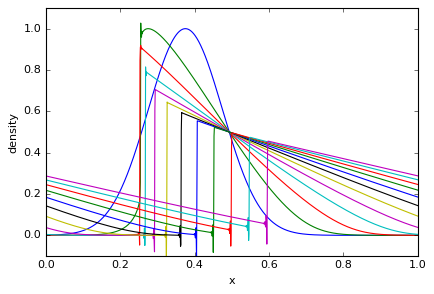

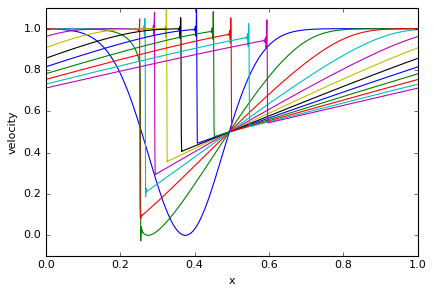

In [57]:
L = 1.           # box size
N = 1001         # number of cells
h = L/(N-1.)     # cell size
vm = 1.          # max velocity
rhom = 1.        # max density
dt = 0.0005*L/vm  # time step

# initial conditions
mu = 3*L/8
sig = L/10
x = np.arange(0., L+h/2., h)
rho = fg(x, mu, sig)
rho = rho/np.amax(rho) * rhom

def run_track(rho, Nt):
    """
        rho = initial density profile
        Nt = number of outputs, every 0.1 of box length
    """
    t = 0.
    tstep = 0.1*L/vm
    tnext = tstep
    k = 1
    den = np.zeros([Nt,N]) 
    den[0] = rho
    while k < Nt:
        #rho = FTCS(rho, h, dt)
        #rho = Lax(rho, h, dt)
        #rho = LaxWendroff(rho, h, dt)
        rho = LaxWendroff2(rho, h, dt)
        t += dt
        if t >= tnext:  
            den[k] = rho
            tnext += tstep
            k += 1
    return den

Nt = 12    # number of outputs
nshow = 12  # show these outputs first

den = run_track(rho, Nt)

plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('density')
[plt.plot(x, den[k], '-') for k in range(nshow)]
plt.show()

plt.ylim(-0.1, 1.1)
plt.xlabel('x')
plt.ylabel('velocity')
[plt.plot(x, v(den[k]), '-') for k in range(nshow)]
plt.show()

<b>Exercise 2:</b> Modify the initial density profile to a uniform density with a small Gaussian bump:
$$
   \rho(x,t=0) = \rho_0 \left({1 + 0.2 \exp{\left(-{(x-\mu)^2 \over 2\sigma^2}\right)}}\right),
$$
with the same $\mu$ and $\sigma$ as above.  It corresponds to a regular traffic with a small congested area.  Consider two cases, $\rho_0 = 0.25 \rho_m$ and $\rho_0 = 0.75 \rho_m$, for light and heavy traffic, respectively. Run the code in both cases. Where does the bump propagate in each case? Interpret this result physically.

In [10]:
def v(rho):
    return vm*(1.-rho/rhom)

def c(rho):
    return vm*(1.-2.*rho/rhom)

def Flux(rho):
    return rho*v(rho)

# periodic boundary conditions
def ip(i):
    return i+1 if (i < N-1) else 0 #i.e., we loop back around to the beginning.
    
def im(i):
    return i-1 if (i > 0) else N-1

# Lax-Wendroff scheme explicitly for this problem
def LaxWendroff2(rho, h, dt):
    rhop = np.array([rho[ip(i)] for i in range(N)])
    rhom = np.array([rho[im(i)] for i in range(N)])
    Fi = Flux(rho)
    Fp = Flux(rhop)
    Fm = Flux(rhom)
    cp = c((rhop+rho)/2.)*(Fp-Fi)
    cm = c((rhom+rho)/2.)*(Fi-Fm)
    r = rho - dt/(2.*h)*(Fp-Fm) + (dt/h)**2/2.*(cp-cm)
    return r

def fg(x, mu, sig):
    return 1/(sig * np.sqrt(2. * np.pi)) * np.exp(-(x - mu)**2/(2 * sig**2))

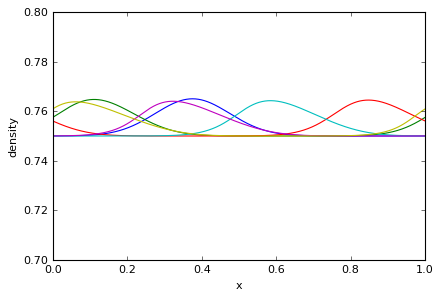

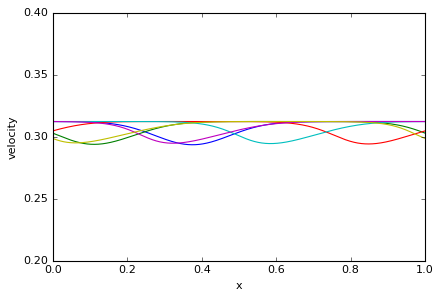

In [50]:
L = 1.           # box size
N = 1001         # number of cells
h = L/(N-1.)     # cell size
vm = 1.25          # max velocity
rhom = 1.        # max density
dt = 0.001*L/vm  # time step - *must* obey v * dt < dx, or otherwise solution will blow up.

# initial conditions
mu = 3*L/8
sig = L/10
x = np.arange(0., L+h/2., h)
rho = 0.75 * rhom * (1 + 0.02 * np.exp(-(x - mu)**2 / (2 * sig * sig)))


def run_track(rho, Nt):
    """
        rho = initial density profile
        Nt = number of outputs, every 0.1 of box length
    """
    t = 0.
    tstep = 0.1*L/vm
    tnext = tstep
    k = 1
    den = np.zeros([Nt,N]) 
    den[0] = rho
    while k < Nt:
        #rho = FTCS(rho, h, dt)
        rho = Lax(rho, h, dt)
        #rho = LaxWendroff(rho, h, dt)
        #rho = LaxWendroff2(rho, h, dt)
        t += dt
        if t >= tnext:  
            den[k] = rho
            tnext += tstep
            k += 1
    return den

Nt = 30    # number of outputs
nshow = 30  # show these outputs first

den = run_track(rho, Nt)

plt.ylim(0.7, 0.8)
plt.xlabel('x')
plt.ylabel('density')
[plt.plot(x, den[k], '-') for k in np.arange(0, Nt, 5)]
plt.show()

plt.ylim(0.2, 0.4)
plt.xlabel('x')
plt.ylabel('velocity')
[plt.plot(x, v(den[k]), '-') for k in np.arange(0, Nt, 5)]
plt.show()

One way to check the error (i.e., to detect artifacts): decrease the step-size, and note what features appear and disappear until you get a converged result.